# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Описание проекта
Заказчик этого исследования — сеть отелей «Как в гостях».  

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.   

Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Бизнес-метрика и другие данные
Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.   

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.
Стоимость номеров отеля:
* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350;
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.  

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.   

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

### Описание данных:
В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:  
* id — номер записи;
* adults — количество взрослых постояльцев;
* arrival_date_year — год заезда;
* arrival_date_month — месяц заезда;
* arrival_date_week_number — неделя заезда;
* arrival_date_day_of_month — день заезда;
* babies — количество младенцев;
* booking_changes — количество изменений параметров заказа;
* children — количество детей от 3 до 14 лет;
* country — гражданство постояльца;
* customer_type — тип заказчика:
    * Contract — договор с юридическим лицом;
    * Group — групповой заезд;
    * Transient — не связано с договором или групповым заездом;
    * Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* days_in_waiting_list — сколько дней заказ ожидал подтверждения;
* distribution_channel — канал дистрибуции заказа;
* is_canceled — отмена заказа;
* is_repeated_guest — признак того, что гость бронирует номер второй раз;
* lead_time — количество дней между датой бронирования и датой прибытия;
* meal — опции заказа:
    * SC — нет дополнительных опций;
    * BB — включён завтрак;
    * HB — включён завтрак и обед;
    * FB — включён завтрак, обед и ужин.
* previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
* previous_cancellations — количество отменённых заказов у клиента;
* required_car_parking_spaces — необходимость места для автомобиля;
* reserved_room_type — тип забронированной комнаты;
* stays_in_weekend_nights — количество ночей в выходные дни;
* stays_in_week_nights — количество ночей в будние дни;
* total_nights — общее количество ночей;
* total_of_special_requests — количество специальных отметок.

### Шаг 1. Откройте файлы с данными

In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

In [427]:
df = pd.read_csv('hotel_train.csv')
df_test = pd.read_csv('hotel_test.csv')
display(df.head())
display(df_test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


In [428]:
display(df.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

### Шаг 2. Предобработка и исследовательский анализ данных

Уберем столбец id за ненадобностью в анализе и модели

In [429]:
df = df.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

Посмотрим что хрянят в себе столбца с типом данных object

In [430]:
list_obj = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
for i in list_obj:
    print(i)
    print(df[i].unique())
    print('-'*50)

arrival_date_month
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
--------------------------------------------------
meal
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
--------------------------------------------------
country
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM'

In [431]:
list_obj = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
for i in list_obj:
    print(i)
    print(df_test[i].unique())
    print('-'*50)

arrival_date_month
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']
--------------------------------------------------
meal
['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']
--------------------------------------------------
country
['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'
 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'
 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'
 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'MDG' 'IDN' 'LTU'
 'ISL' 'TUR' 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UZB' 'UKR' 'IND'
 'CZE' 'URY' 'NZL' 'NPL' 'SRB' 'CPV' 'IRN' 'KAZ' 'BHS' 'SUR' 'CUB' 'PAK'
 'MAC' 'CYP' 'JOR' 'GRC' 'KWT' 'TWN' 'VNM' 'SGP' 'DOM' 'VEN' 'SEN' 'BLR'
 'TZA' 'LIE' 'GNB' 'SAU' 'DZA' 'PER' 'AZE' 'EGY' 'ETH' 'KEN' 'THA' 'MLT'
 'ECU' 'AND' 'IMN' 'BHR' 'TUN' 'MNE' 'MEX' 'BEN' 'MOZ' 'UMI' 'JEY' 'MYT'
 'QAT' 'BGD' 'GAB' 'CIV' 'ZWE' 'GTM' 'ALB' 'GHA' 'ATA' 'ASM' 'PAN' 'CRI'
 'MCO' 'MUS' '

Столбцам meal и reserved_room_type требуется предобработка и исключение дубликатов

In [432]:
df['meal'] = df['meal'].str.strip()
df['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [433]:
df_test['meal'] = df_test['meal'].str.strip()
df_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

In [434]:
df['reserved_room_type'] = df['reserved_room_type'].str.strip()
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()
df_test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

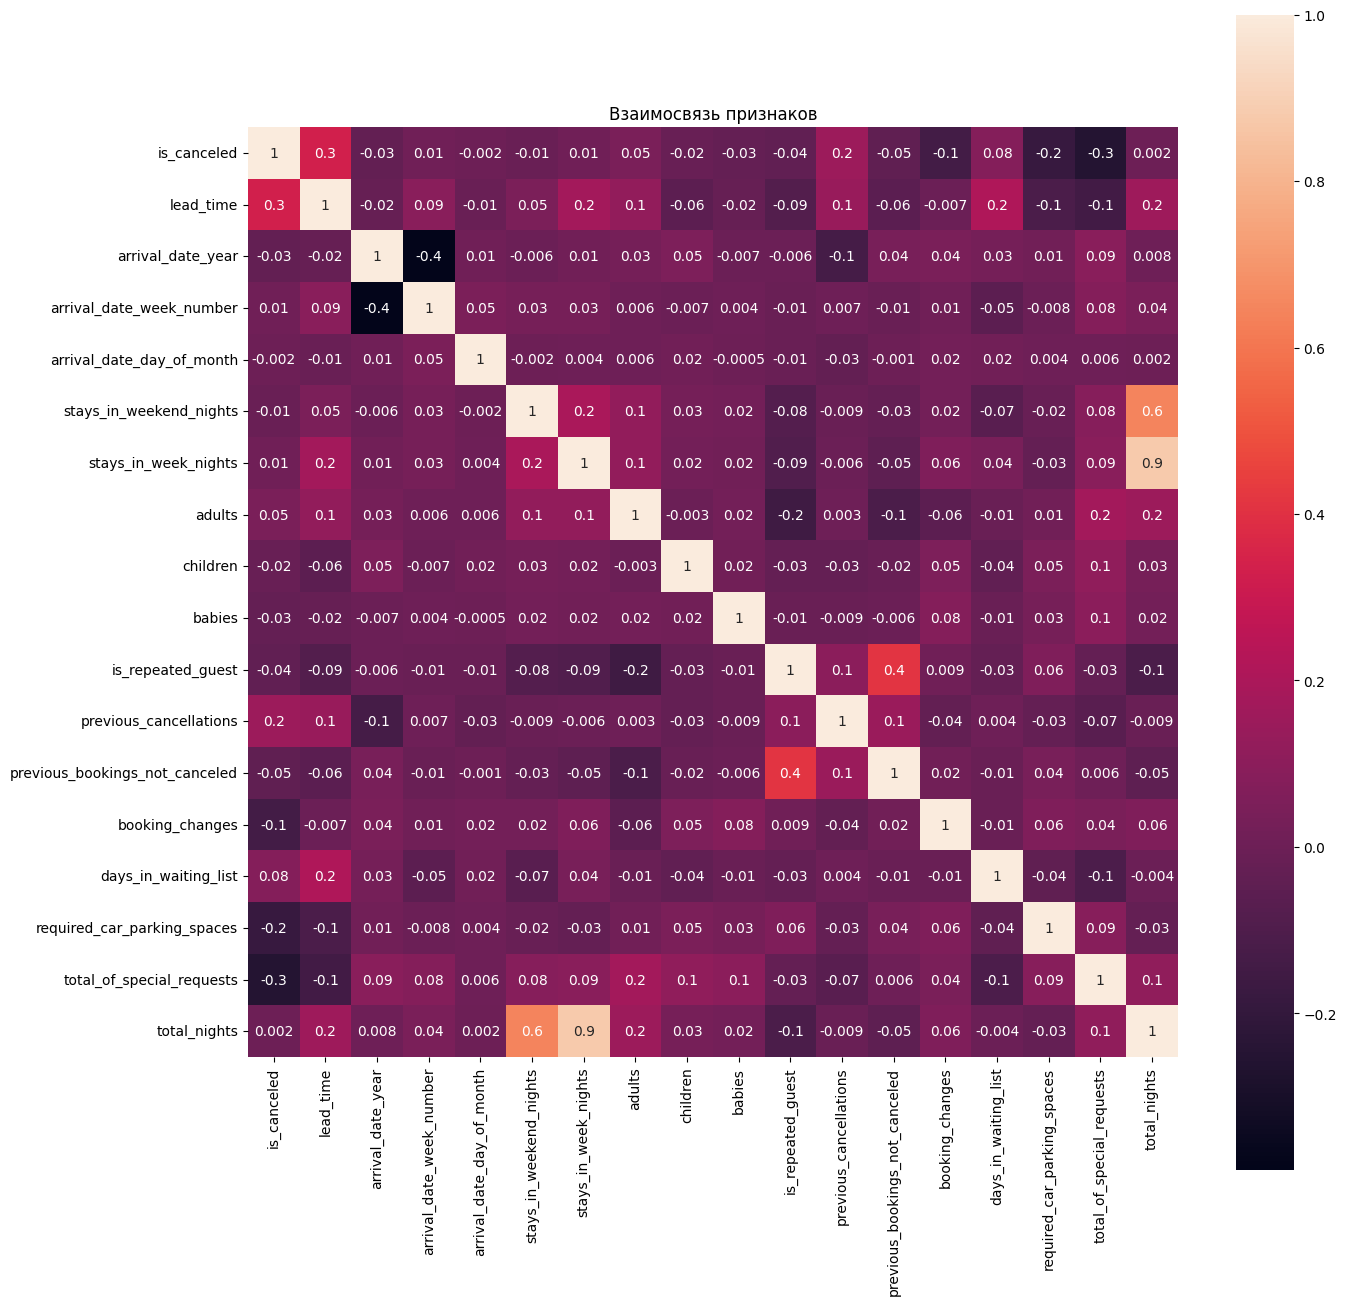

In [435]:
fig, ax = plt.subplots(figsize = (15,15))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.1g', ax=ax, square=True)
plt.title('Взаимосвязь признаков')
plt.show()

В наибольшей степени на целевой признак влияют признаки lead_time, previous_cancellations(прямая зависимость), required_car_parking_spaces, total_of_special_requests(обратная зависимость). Остальные признаки влияют менее значительно.  

Также обратим внимание на мультиколлинеарность некоторых признаков, это такие пары как:  

* total_nights - stays_in_weekend_nights
* total_nights - stays_in_week_nights
* previous_bookings_not_canceled - is_repeated_guest
* arrival_date_week_number - arrival_date_year

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Сохраним ключевые переменные для вычислений:

In [436]:
BUDGET = 400000
SUMMER_COEF = 1.4
DEMISEASON_COEF = 1.2
A_PRICE = 1000
A_SERVICE = 400
B_PRICE = 800
B_SERVICE = 350
C_PRICE = 600
C_SERVICE = 350
D_PRICE = 550
D_SERVICE = 150
E_PRICE = 500
E_SERVICE = 150
F_PRICE = 450
F_SERVICE = 150
G_PRICE = 350
G_SERVICE = 150
SUMMER_MONTHS = [ 'June', 'July', 'August' ]
DEMISEASON_MONTHS = ['September', 'October', 'November' , 'March', 'April', 'May']

Посчитаем прибыль для каждого клиента, для этого сначала создадим отдельный столбец с сезонными коэффициентами:

In [437]:
def coef(row):
    month = row['arrival_date_month']
    if month in SUMMER_MONTHS:
        return SUMMER_COEF
    elif month in DEMISEASON_MONTHS:
        return DEMISEASON_COEF
    else:
        return 1

In [438]:
df['coef'] = df.apply(coef, axis=1)
df_test['coef'] = df_test.apply(coef, axis=1)

Определим функцию для подсчета прибыли с каждого клиента:

In [439]:
def calc_0(price, service, days, coef):
    '''формула для расчета прибыли'''
    res = (days*price*coef)-(days+1)//2*service
    return res
    
def calc_1(price, service, coef):
    '''убыток в случае отмены бронирования'''
    res = 0-((price*coef)+service)
    return res
    
def calc_deposit(price, service, coef):
    '''формула для расчета депозита в случае предсказания отмены'''
    res = ((price*coef)+service)*0.8
    return res

In [440]:
def income_before(row):
    coef = row['coef']
    days = row['total_nights']
    cancel = row['is_canceled']
    price = row['price']
    service = row['service']
    if cancel == 0:
        return calc_0(price,service,days,coef)
    else:
        return calc_1(price, service, coef)

Для удобства создалим датафрейм prices с ценами на уборку и номера:

In [441]:
prices = {'reserved_room_type' : ['A','B', 'C', 'D', 'E', 'F', 'G'], 'price': [A_PRICE, B_PRICE, C_PRICE, D_PRICE, E_PRICE, F_PRICE, G_PRICE], 'service' : [A_SERVICE, B_SERVICE, C_SERVICE, D_SERVICE, E_SERVICE, F_SERVICE, G_SERVICE]}
prices = pd.DataFrame(prices)
prices

,reserved_room_type,price,service
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


Объединим датафреймы по столбцу reserved_room_type:

In [442]:
df = df.merge(prices, on='reserved_room_type', how='left')
df_test = df_test.merge(prices, on='reserved_room_type', how='left')

In [444]:
df['income_before'] = df.apply(income_before, axis=1)
df_test['income_before'] = df_test.apply(income_before, axis=1)
df['income_before'].sort_values()

38190    -1800.0
38355    -1800.0
38356    -1800.0
38357    -1800.0
38358    -1800.0
          ...   
13734    12000.0
58016    12000.0
6051     12000.0
426      12000.0
13423    12000.0
Name: income_before, Length: 65229, dtype: float64

In [445]:
income_before = df_test['income_before'].sum() / 8 * 12
df_income = df_test.copy()
print('Прибыль до внедрения депозитов в год: ', int(income_before), 'руб.')

Прибыль до внедрения депозитов в год:  52951155 руб.


### Шаг 4. Разработка модели ML

Переведем названия месяцев в столбце arrival_date_month в формат числа

In [446]:
df_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [447]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [448]:
df['arrival_date_month'] = pd.to_datetime(df['arrival_date_month'], format='%B').dt.month
df_test['arrival_date_month'] = pd.to_datetime(df_test['arrival_date_month'], format='%B').dt.month
df_test['arrival_date_month'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8])

In [449]:
df['country'].nunique()

155

In [450]:
df_test['country'].nunique()

143

Преобразуем признак country. В этом столбце 155 и 143 уникальных значения. Посмотрим, как часто встречается каждая из стран. Выведем на экран топ 20.

In [451]:
pd.concat([df, df_test])['country'].value_counts()[:20]

country
PRT    38718
FRA     9451
GBR     9036
ESP     6832
DEU     6265
ITA     3480
IRL     2505
BEL     2127
BRA     1969
NLD     1875
USA     1782
CHE     1476
AUT     1155
CN       957
CHN      921
SWE      862
POL      770
ISR      639
RUS      513
NOR      503
Name: count, dtype: int64

Страны, которые встречаются менее 1000 раз назовем категорией 'Others'.
Соответсвенно, когда мы будем передавать модель в продакшн, нам необходимо будет, чтобы данные поступали нам именно в таком формате. Для этого можно изменить варианты выбора страны в форме, которую заполняет клиент при бронировании. Либо же добавить этап предобработки данных, на котором все страны, не входящие в наиболее встречающиеся были отмечены как 'Others'.

In [452]:
top_10 = pd.concat([df, df_test])['country'].value_counts()[lambda x: x >= 1000]
list_top_10 = list(top_10.to_dict().keys())
list_top_10

['PRT',
 'FRA',
 'GBR',
 'ESP',
 'DEU',
 'ITA',
 'IRL',
 'BEL',
 'BRA',
 'NLD',
 'USA',
 'CHE',
 'AUT']

In [453]:
df['country'] = df['country'].where(lambda x: x.isin(list_top_10), 'Others')
df_test['country'] = df_test['country'].where(lambda x: x.isin(list_top_10), 'Others')

In [454]:
df_test

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,coef,price,service,income_before
0,1,74.0,2017,1,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1.0,1000,400,-1400.0
1,1,62.0,2017,1,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,1000,400,-1400.0
2,1,62.0,2017,1,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,1000,400,-1400.0
3,1,71.0,2017,1,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,1000,400,-1400.0
4,1,172.0,2017,1,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.0,1000,400,-1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,0,164.0,2017,8,35,31,2,4,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1.4,1000,400,7200.0
32408,0,21.0,2017,8,35,30,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,1.4,1000,400,8200.0
32409,0,23.0,2017,8,35,30,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.4,1000,400,8200.0
32410,0,34.0,2017,8,35,31,2,5,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,1.4,550,150,4790.0


Предварительно удалим лишние столбцы из датасетов обучения и теста:

In [455]:
df = df.drop(['income_before', 'coef', 'price', 'service'], axis=1).sort_index(axis=1)
df_test = df_test.drop(['income_before', 'coef', 'price', 'service'], axis=1).sort_index(axis=1)
        

Столбцы с категориальными данными, преобразуем их техников OHE

In [457]:
# df = pd.get_dummies(df, drop_first=True, dtype=int)
# df_test = pd.get_dummies(df_test, drop_first=True, dtype=int)
# df

categorical = ['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(df[categorical])

tmp = pd.DataFrame(ohe.transform(df[categorical]).toarray(), 
                                   columns=ohe.get_feature_names_out(),
                                   index=df.index)
tmp_test = pd.DataFrame(ohe.transform(df_test[categorical]).toarray(), 
                                   columns=ohe.get_feature_names_out(),
                                   index=df_test.index)

df.drop(categorical, axis=1, inplace=True)
df = df.join(tmp)

df_test.drop(categorical, axis=1, inplace=True)
df_test = df_test.join(tmp_test)

Проведём масштабирование признаков:

In [458]:
numeric = [
    'adults', 'children', 'booking_changes', 'babies', 'days_in_waiting_list', 'previous_cancellations', 'lead_time',
    'total_nights', 'total_of_special_requests', 'arrival_date_day_of_month', 'arrival_date_year', 'arrival_date_month', 
    'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'is_repeated_guest', 'previous_bookings_not_canceled',
    'required_car_parking_spaces', 'booking_changes'
    ]
scaler = StandardScaler()
scaler.fit(df[numeric])
df[numeric] = scaler.transform(df[numeric])
df_test[numeric] = scaler.transform(df_test[numeric])



Определим целевой признак в обоих выборках:

In [459]:
feature_train = df.drop(['is_canceled'], axis=1).sort_index(axis=1)
target_train = df['is_canceled']
feature_test = df_test.drop(['is_canceled'], axis=1).sort_index(axis=1) 
target_test = df_test['is_canceled']

Проверим, как часто в целевом признаке встречается класс «1» или «0»:

is_canceled
0    0.631391
1    0.368609
Name: proportion, dtype: float64

Соотношение отменивших бронь клиентов: 0.5838047832948888


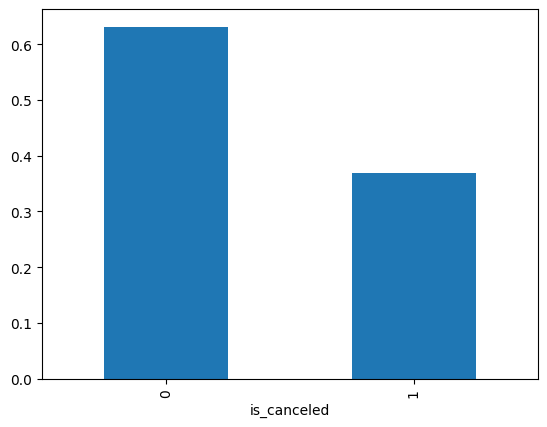

In [461]:
df['is_canceled'].value_counts(normalize=True).plot.bar()
display(df['is_canceled'].value_counts(normalize=True))
print('Соотношение отменивших бронь клиентов:', df['is_canceled'].value_counts(normalize=True)[1]/df['is_canceled'].value_counts(normalize=True)[0])
plt.show()

Классы сбалансированы. (Дисбаланс классов считаем при доле одного из классов менее 25%)

Метрика для задачи выберем: f1_score. В данной задаче нам важна как полнота предсказаний модели (важно, чтобы модель могла распознать как можно больше клиентов, которые отменили бронь), так и ее точность (важно, чтобы среди тех клиентов, которых модель пометила как ненадежных, как можно больше действительно таковыми бы являлись).

При сравнении моделей в качестве определяющей метрики будем использовать точность (precision), тк она показывает долю истинно положительных ответов, то есть те бронирования, которые действительно будут отменены - будет важно получить как можно более точное число отмененных бронирований.

Для вычисления метрик и построения кривой определим функцию metrics_func:

In [462]:
def metric_func(model):
    model.fit(feature_train, target_train)
    predicted_test = model.predict(feature_test)
    probabilities_test = model.predict_proba(feature_test)
    probabilities_one_test = probabilities_test[:,1]
    precision_best = 0
    threshold_best = 0
    predicted_test_best = 0
    for threshold in np.arange(0, 0.5, 0.01):
        predicted_test = probabilities_one_test>threshold
        precision = precision_score(target_test, predicted_test)
        if precision > precision_best:
            precision_best = precision
            threshold_best = threshold
            predicted_test_best = predicted_test
    print('Точность:', precision_best, 'при пороге равном', threshold_best)
    print('Доля правильных ответов:', accuracy_score(target_test, predicted_test_best)) 
    print('F1-мера:', f1_score(target_test, predicted_test_best))
    print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_test))
    print('Матрица ошибок:')
    print(confusion_matrix(target_test, predicted_test_best))

    
    #ROC-кривая
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    plt.figure()
    plt.plot([0,1],[0,1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    
    plt.show()
    return predicted_test_best, probabilities_one_test, model

### Логистическая регрессия  
C помощью функции cross_val_score рассмотрим средние оценки качества модели:

In [478]:
model_lr = LogisticRegression(random_state=123, solver='liblinear', class_weight='balanced')
scores_train = cross_val_score(model_lr, feature_train, target_train, cv=8)
print('Средняя оценка качества модели на обучающей выборке:', scores_train.mean())

Средняя оценка качества модели на обучающей выборке: 0.7206463450375922


Точность: 0.5484663191659984 при пороге равном 0.49
Доля правильных ответов: 0.67120202394175
F1-мера: 0.6725255815382724
AUC-ROC: 0.822331743859348
Матрица ошибок:
[[10812  9009]
 [ 1648 10943]]


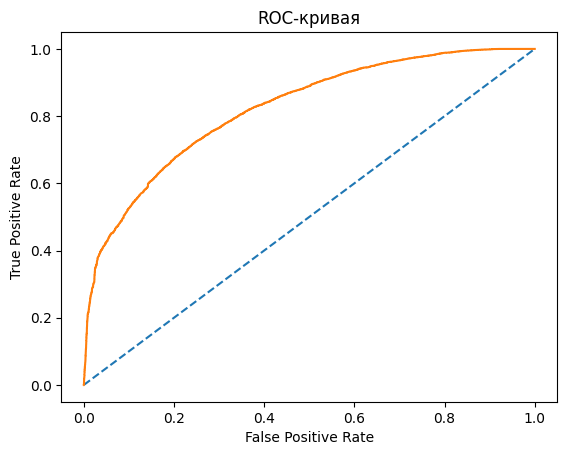

In [479]:
predictions_lr, probabilities_lr, model_lr = metric_func(model_lr)

### Дерево решений
Подберем оптимальные параметры с помощью GridSearchCV:

In [465]:
# params_tree = {'max_depth': range(1,16)}
# model_t = DecisionTreeClassifier(random_state=123)
# grid_t = GridSearchCV(model_t, params_tree)
# grid_t.fit(feature_train,target_train)
# print(grid_t.best_params_)

In [466]:
# model = XGBClassifier()
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7]}
# grid_search = GridSearchCV(model, param_grid, cv=5)
# grid_search.fit(feature_train,target_train)
# print(grid_search.best_params_)

In [467]:
model_t = DecisionTreeClassifier(random_state=123, max_depth=3, class_weight='balanced')
scores_train = cross_val_score(model_t, feature_train, target_train, cv=8)
print('Средняя оценка качества модели на обучающей выборке:', scores_train.mean())

Средняя оценка качества модели на обучающей выборке: 0.7092870493791761


Точность: 0.5911062160115647 при пороге равном 0.42
Доля правильных ответов: 0.6932000493644329
F1-мера: 0.6333062910244118
AUC-ROC: 0.7522855327558745
Матрица ошибок:
[[13881  5940]
 [ 4004  8587]]


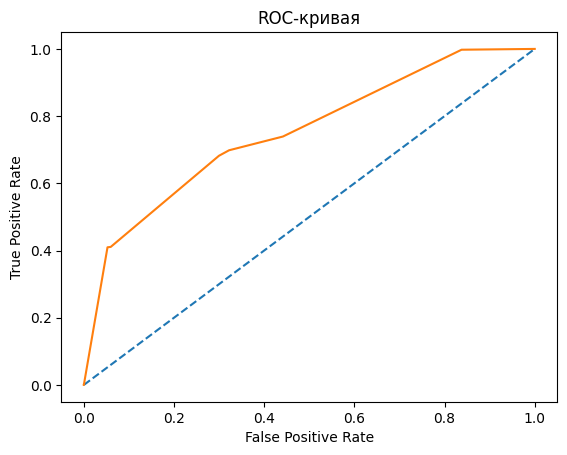

In [468]:
predictions_t, probabilities_t, model_t = metric_func(model_t)

### Случайный лес

In [469]:
model_f = RandomForestClassifier(random_state=123, max_depth=3, n_estimators=50, class_weight='balanced')
scores_train = cross_val_score(model_f, feature_train, target_train, cv=8)
print('Средняя оценка качества модели на обучающей выборке:', scores_train.mean())

Средняя оценка качества модели на обучающей выборке: 0.7542216113728306


Точность: 0.766081191113179 при пороге равном 0.49
Доля правильных ответов: 0.7526841910403554
F1-мера: 0.6216726448933358
AUC-ROC: 0.8058552645974979
Матрица ошибок:
[[17810  2011]
 [ 6005  6586]]


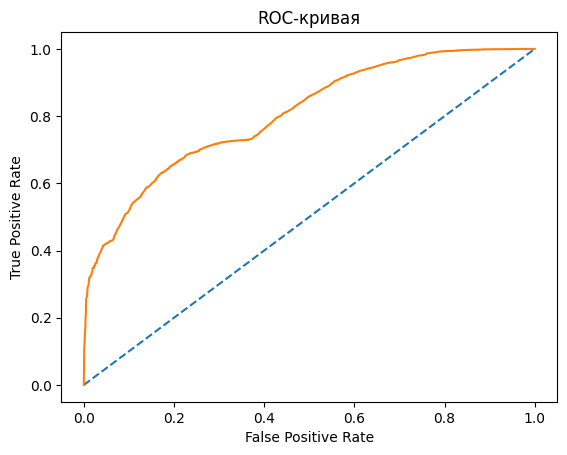

In [470]:
predictions_f, probabilities_f, model_f = metric_func(model_f)

### Оценка прибыли

In [471]:
def income_after(row):
    coef = row['coef']
    days = row['total_nights']
    cancel = row['is_canceled']
    price = row['price']
    service = row['service']
    predictions = row['predictions']
    if cancel*predictions == 0:
        return calc_0(price,service,days,coef)
    else:
        return calc_deposit(price, service, coef)

In [472]:
df_income['predictions'] = predictions_f*1 # добавим столбец с предсказаниями в тестовую выборку
df_income['income_after'] = df_income.apply(income_after, axis=1)
income_after = df_income['income_after'].sum() / 8 * 12
print('Прибыль до внедрения депозитов: ', int(income_before), 'руб.')
print('Прогнозируемая прибыль после внедрения депозитов:', int(income_after), 'руб.')
print('Разность прибылей после и до внедрения: ', int(income_after-income_before), 'руб.')

Прибыль до внедрения депозитов:  52951155 руб.
Прогнозируемая прибыль после внедрения депозитов: 117966915 руб.
Разность прибылей после и до внедрения:  65015760 руб.


Самой прибыльной моделью оказалась RandomForestClassifier: прибыль внедрения 62313969 руб., DecisionTreeClassifier 59695719 руб., LogisticRegression 60116139 руб.

### Шаг 5. Опишите портрет «ненадёжного» клиента

Для описания ненадёжного клиента воспользуемся функцией SelectFromModel:

In [473]:
smf = SelectFromModel(model_f, threshold=-np.inf, max_features = 7)
smf.fit(feature_train, target_train)
features_index = smf.get_support()
features_1 = feature_train.columns[features_index]
features_1

Index(['booking_changes', 'country_PRT', 'distribution_channel_TA/TO',
       'lead_time', 'previous_cancellations', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

По итогам исследования, можно описать тип ненадежного клиента - вероятность отмены бронирования повышается, если:

* большое количество дней между датой бронирования и датой прибытия;
* у клиента ранее уже были отмены;
* большое количество изменений параметров заказа;
* клиенту требуется большее кол-во парковочных мест;
* большое количество специальных отметок;
* клиент из страны PRT
* бронирование происходило на прямую;

### Шаг 6. Напишите общий вывод

В результате сравнения полученных моделей наилучший результат показывает модель решающего дерева, тк она имеет наибольшее значение точности для выбранного порога, а точность показывает долю истинно положительных ответов, то есть те бронирования, которые действительно будут отменены:

* F1-мера: 0.6589
* AUC-ROC: 0.8090
* Precision (точность): 0.7309
* Доля правильных ответов: 0.7587

Прибыль после внедрения депозитов увеличилась более чем в 2 раза, что полностью покрывает расходы на разработку модели:

* Прибыль до внедрения депозитов: 52951155 руб.
* Прогнозируемая прибыль после внедрения депозитов: 115265124 руб.

Выгрузка моделей в файлы:

In [474]:
import pickle

In [475]:
pickle.dump(model_f, open('booking_cancel_pred.pkl', 'wb'))

In [476]:
pickle.dump(scaler, open('scaler_booking_cancel_pred.pkl', 'wb'))

In [477]:
pickle.dump(ohe, open('ohe_booking_cancel_pred.pkl', 'wb'))